In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.style.use('dark_background')
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/rajupreti/PersonalProjects/refs/heads/main/SentimentAnalysis/csci_sentiment_data.csv', delimiter=';')

In [3]:
df.head()

,ID,Comments
0,1,Saudi Arabia's green hydrogen ambitions are a ...
1,2,C) #Aramco buys 50% in BHIG - a subsidiary of ...
2,3,Once again do tell how that means Saudi Arabia...
3,4,SaudiArabia is a small country that's been kic...
4,5,Maybe we should get serious then and start com...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        100 non-null    int64 
 1   Comments  100 non-null    object
dtypes: int64(1), object(1)
memory usage: 1.7+ KB


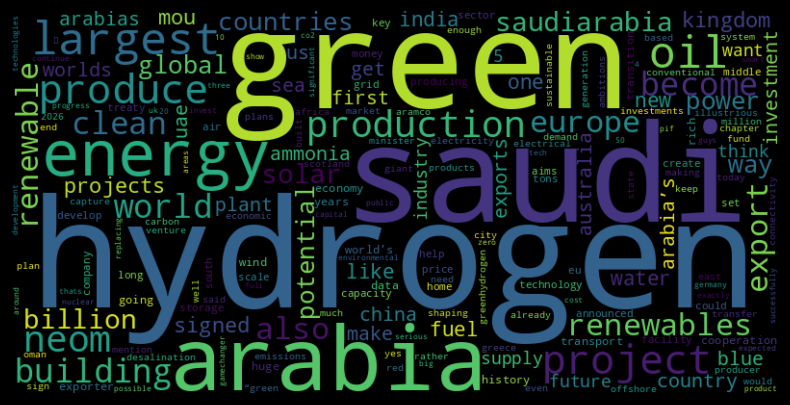

In [5]:
tweets = df['Comments'].astype(str)

all_words = []
for tweet in tweets:
    words = tweet.lower().translate(str.maketrans('', '', string.punctuation)).split()
    all_words.extend(words)

stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)

wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [6]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [7]:
!pip install tqdm
from tqdm import tqdm

In [8]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [9]:
count_roberta= {}
for i, row in tqdm(df.iterrows(), total= len(df)):
  try:
    text= row['Comments']
    id= row['ID']
    roberta_new= polarity_scores_roberta(text)
    count_roberta[id]= roberta_new
  except RuntimeError as e :
    print(f'Error for {id}: {e}')


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [10]:
roberta_result= pd.DataFrame(count_roberta).T
roberta_result

,roberta_neg,roberta_neu,roberta_pos
1,0.002982,0.088634,0.908384
2,0.010075,0.896768,0.093157
3,0.174743,0.627047,0.198209
4,0.499075,0.390162,0.110763
5,0.275065,0.587217,0.137718
...,...,...,...
96,0.125875,0.399380,0.474745
97,0.005482,0.477759,0.516759
98,0.007874,0.715287,0.276839
99,0.058516,0.539783,0.401702


In [11]:
roberta_result_agg = roberta_result.agg(['mean', 'std'])
roberta_result_agg

,roberta_neg,roberta_neu,roberta_pos
mean,0.080537,0.444368,0.475095
std,0.153780,0.247837,0.301992


<ipython-input-12-1fdbb49db01f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roberta_result_agg.columns, y=roberta_result_agg.loc['mean'], palette=colors)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

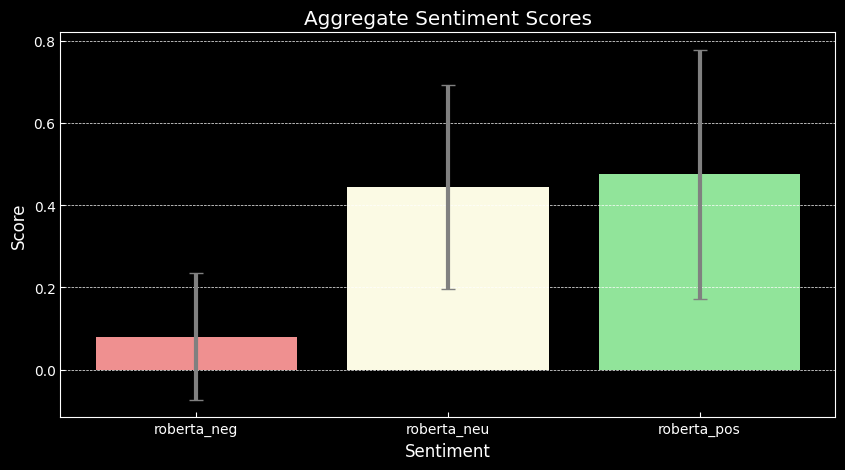

In [12]:
plt.figure(figsize=(10, 5))

colors = {'roberta_pos': '#83F28F', 'roberta_neu': '#FFFEE0', 'roberta_neg': '#FF8080'}
sns.barplot(x=roberta_result_agg.columns, y=roberta_result_agg.loc['mean'], palette=colors)

plt.errorbar(roberta_result_agg.columns, roberta_result_agg.loc['mean'], yerr=roberta_result_agg.loc['std'], fmt='none', capsize=5, ecolor='grey', elinewidth=3) # Changed ecolor and added elinewidth
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Aggregate Sentiment Scores')
sns.set_style('darkgrid')
plt.show()

In [13]:
roberta_result['sentiment'] = roberta_result.apply(lambda row: row.idxmax(), axis=1)
sentiment_counts = roberta_result['sentiment'].value_counts()
print(sentiment_counts)

sentiment
roberta_neu    53
roberta_pos    44
roberta_neg     3
Name: count, dtype: int64


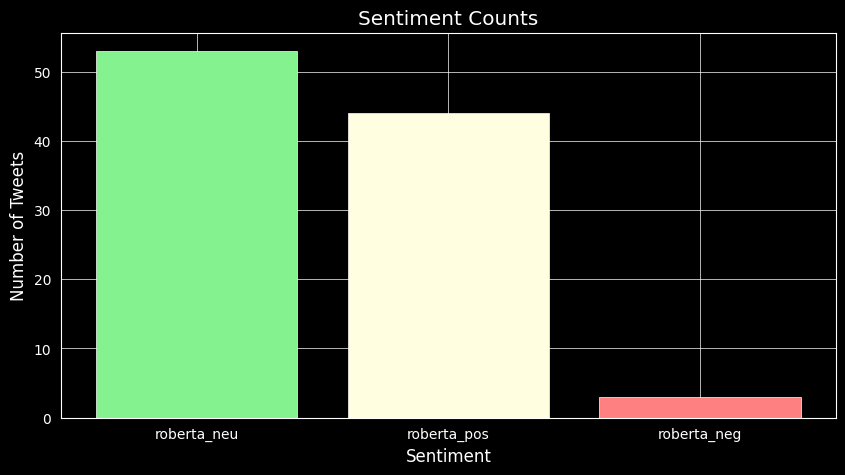

In [15]:
plt.figure(figsize=(10, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#83F28F', '#FFFEE0', '#FF8080'])
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.title('Sentiment Counts')
plt.style.use('dark_background')
plt.show()